In [1]:
import numpy as np
import pandas as pd
import os,cv2,random,time,shutil,csv
import tensorflow as tf
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from tqdm import tqdm
import json,os,cv2,keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization,Dense,GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.preprocessing.image import load_img

In [2]:
tf.keras.backend.clear_session()

In [3]:
!wget https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-snake-breed-detection/identify-the-snake-breed-5-66d9a9f5/8a95c26e1bab11eb.zip

--2022-08-13 12:13:54--  https://he-s3.s3.amazonaws.com/media/hackathon/hackerearth-deep-learning-challenge-snake-breed-detection/identify-the-snake-breed-5-66d9a9f5/8a95c26e1bab11eb.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.124.236
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.124.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100929731 (96M) [application/zip]
Saving to: ‘8a95c26e1bab11eb.zip’

8a95c26e1bab11eb.zi 100%[===================>]  96.25M  16.8MB/s    in 7.0s    

2022-08-13 12:14:01 (13.7 MB/s) - ‘8a95c26e1bab11eb.zip’ saved [100929731/100929731]



In [4]:
!unzip *.zip


Streaming output truncated to the last 5000 lines.
  inflating: dataset/train/b70a166bfe.jpg  
  inflating: dataset/train/d31875b68e.jpg  
  inflating: dataset/train/22c66793fb.jpg  
  inflating: dataset/train/a468b1390f.jpg  
  inflating: dataset/train/9e43d2cedc.jpg  
  inflating: dataset/train/2e0299e991.jpg  
  inflating: dataset/train/e0b85d8ff1.jpg  
  inflating: dataset/train/6a651ec04a.jpg  
  inflating: dataset/train/46c87716a5.jpg  
  inflating: dataset/train/8c40d4f073.jpg  
  inflating: dataset/train/96e4fb744c.jpg  
  inflating: dataset/train/794a698960.jpg  
  inflating: dataset/train/dad1934f35.jpg  
  inflating: dataset/train/a1c66a2b3c.jpg  
  inflating: dataset/train/b62484a8e4.jpg  
  inflating: dataset/train/09462814f1.jpg  
  inflating: dataset/train/97dbdb4dd0.jpg  
  inflating: dataset/train/3bd7f56164.jpg  
  inflating: dataset/train/a2576a2fa1.jpg  
  inflating: dataset/train/f462f66aa6.jpg  
  inflating: dataset/train/740e1a7fca.jpg  
  inflating: dataset/trai

In [5]:
train_dir='../content/dataset/train'
test_dir='../content/dataset/test'


In [6]:
labels_dataframe=pd.read_csv('../content/dataset/train.csv')
sample_df=pd.read_csv('../content/dataset/test.csv')

In [7]:
sample_df.head()

,image_id
0,7ede553357
1,3500b219e4
2,d43a78d6d9
3,1f36f26994
4,8cb85fc58e


In [8]:
labels_dataframe.head()

,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [9]:
labels_dataframe


,image_id,breed
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix
...,...,...
5503,5f0c970adf,lampropeltis-triangulum
5504,f6a4287fac,pantherophis-alleghaniensis
5505,d3c10e63e1,thamnophis-sirtalis
5506,61ef50879c,pituophis-catenifer


In [10]:
labels_dataframe.shape


(5508, 2)

In [11]:
labels_dataframe.isnull().sum()


image_id    0
breed       0
dtype: int64

In [12]:
print("No of Snakes's images in train directory",len(os.listdir(train_dir)))
print("No of Snakes images in test directory",len(os.listdir(test_dir)))

No of Snakes's images in train directory 5508
No of Snakes images in test directory 2361


In [13]:
labels_dataframe['breed'].value_counts()


thamnophis-sirtalis            509
storeria-dekayi                412
pantherophis-obsoletus         366
crotalus-atrox                 354
pituophis-catenifer            298
nerodia-sipedon                259
agkistrodon-contortrix         206
lampropeltis-triangulum        197
diadophis-punctatus            184
pantherophis-alleghaniensis    172
nerodia-erythrogaster          171
lampropeltis-californiae       166
opheodrys-aestivus             152
agkistrodon-piscivorus         147
crotalus-horridus              142
coluber-constrictor            129
heterodon-platirhinos          118
thamnophis-proximus            112
nerodia-rhombifer              104
thamnophis-radix               100
pantherophis-guttatus          100
haldea-striatula                98
pantherophis-spiloides          92
rhinocheilus-lecontei           91
storeria-occipitomaculata       87
masticophis-flagellum           83
crotalus-viridis                83
thamnophis-marcianus            82
crotalus-ruber      

In [14]:
unique_features = labels_dataframe['breed'].unique()
len(unique_features)

35

In [15]:
labels_dataframe.columns=['filename','class']
labels_dataframe.head()

,filename,class
0,a8b3ad1dde,nerodia-erythrogaster
1,8b492b973d,pantherophis-vulpinus
2,929b99ea92,thamnophis-sirtalis
3,bbac7385e2,pantherophis-obsoletus
4,ef776b1488,agkistrodon-contortrix


In [16]:
unique_features = labels_dataframe['class'].unique()
len(unique_features)


35

# 1-Splitting Data 90:10

In [17]:
from sklearn.model_selection import train_test_split

training = labels_dataframe.sample(frac = 0.9)
validation = labels_dataframe.drop(training.index)

In [18]:
training.head()


,filename,class
4131,89b8391c26,pantherophis-alleghaniensis
3519,c725618869,pantherophis-emoryi
5461,d1565ba6c9,pantherophis-spiloides
5365,d3064cc972,nerodia-rhombifer
4649,61eff497a3,pituophis-catenifer


In [19]:
validation.head()


,filename,class
18,b0f58084e4,thamnophis-elegans
68,7f6754b25d,thamnophis-radix
75,45652aebed,pantherophis-spiloides
84,d7b05b95e9,pantherophis-obsoletus
113,ad19d7bf51,pantherophis-obsoletus


In [20]:
validation.shape


(551, 2)

In [21]:
training['filename'] = '/content/dataset/train/' + training['filename']
training.head()

,filename,class
4131,/content/dataset/train/89b8391c26,pantherophis-alleghaniensis
3519,/content/dataset/train/c725618869,pantherophis-emoryi
5461,/content/dataset/train/d1565ba6c9,pantherophis-spiloides
5365,/content/dataset/train/d3064cc972,nerodia-rhombifer
4649,/content/dataset/train/61eff497a3,pituophis-catenifer


In [22]:
validation['filename'] = '/content/dataset/train/' + validation['filename']
validation.head()

,filename,class
18,/content/dataset/train/b0f58084e4,thamnophis-elegans
68,/content/dataset/train/7f6754b25d,thamnophis-radix
75,/content/dataset/train/45652aebed,pantherophis-spiloides
84,/content/dataset/train/d7b05b95e9,pantherophis-obsoletus
113,/content/dataset/train/ad19d7bf51,pantherophis-obsoletus


In [23]:
training.shape


(4957, 2)

In [24]:
def append_ext(fn):
    return fn+".jpg"

training["filename"]=training["filename"].apply(append_ext)
training.head()

,filename,class
4131,/content/dataset/train/89b8391c26.jpg,pantherophis-alleghaniensis
3519,/content/dataset/train/c725618869.jpg,pantherophis-emoryi
5461,/content/dataset/train/d1565ba6c9.jpg,pantherophis-spiloides
5365,/content/dataset/train/d3064cc972.jpg,nerodia-rhombifer
4649,/content/dataset/train/61eff497a3.jpg,pituophis-catenifer


In [25]:
def append_ext(fn):
    return fn+".jpg"

validation["filename"]=validation["filename"].apply(append_ext)
validation.head()

,filename,class
18,/content/dataset/train/b0f58084e4.jpg,thamnophis-elegans
68,/content/dataset/train/7f6754b25d.jpg,thamnophis-radix
75,/content/dataset/train/45652aebed.jpg,pantherophis-spiloides
84,/content/dataset/train/d7b05b95e9.jpg,pantherophis-obsoletus
113,/content/dataset/train/ad19d7bf51.jpg,pantherophis-obsoletus


# Random 16 images from training dataset

In [26]:
sample_df = training.sample(16)
files = sample_df['filename'].tolist()
targets = sample_df['class'].tolist()

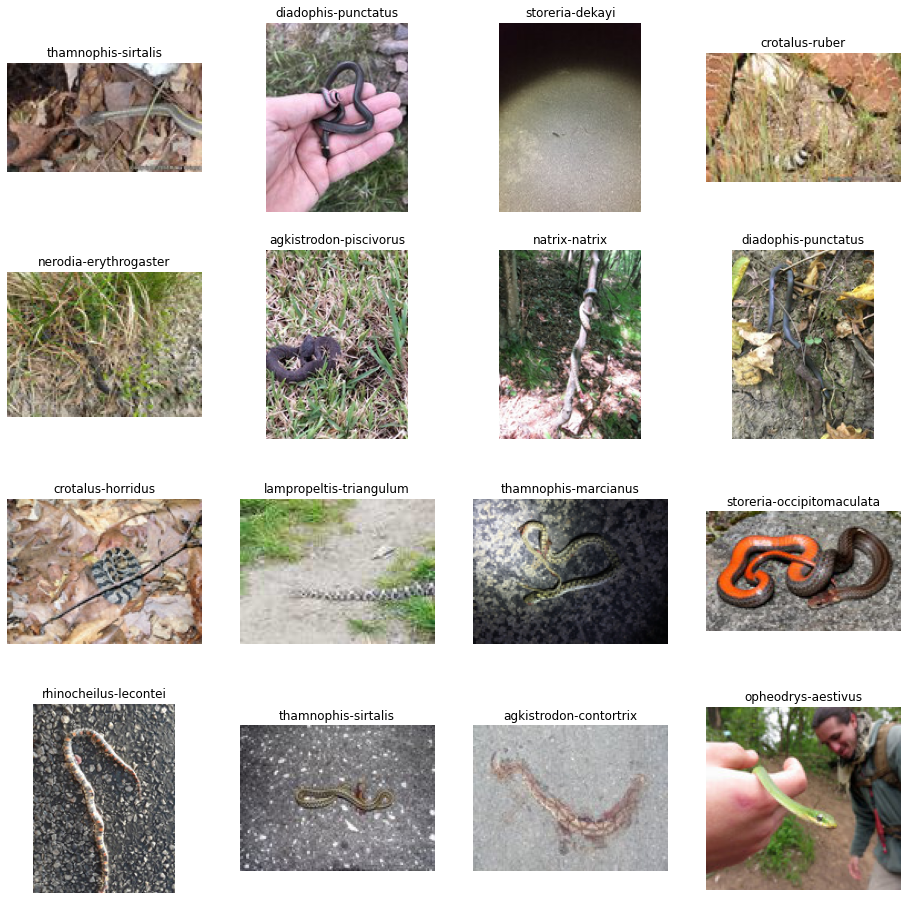

In [27]:
nrows = 4
ncols = 4
fig = plt.gcf()
fig.set_size_inches(nrows * 4,nrows * 4)

for i, (img_path, targets) in enumerate(zip(files,targets)):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(targets)

plt.show()

 3: Image augmentation



In [28]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                rotation_range=20,
                                                                horizontal_flip=True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                rotation_range=20,
                                                                horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training,
    directory='/content/dataset/train',
    target_size=(256,256),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=validation,
    directory='/content/dataset/train',
    target_size=(256,256),
    class_mode='categorical'
)

Found 4957 validated image filenames belonging to 35 classes.
Found 551 validated image filenames belonging to 35 classes.


# 5 CNN Model

In [ ]:
tf.keras.backend.clear_session()

In [29]:
model = tf.keras.Sequential([
                                tf.keras.layers.InputLayer(input_shape=(256,256,3)),
                                tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
                                tf.keras.layers.MaxPooling2D(2,2),
                                tf.keras.layers.Flatten(),
                                tf.keras.layers.Dense(512, activation='relu'),
                                tf.keras.layers.Dropout(0.2),
                                tf.keras.layers.Dense(len(unique_features), activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 492032)            0         
                                                                 
 dense (Dense)               (None, 512)               2

In [30]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Custom callbacks

In [31]:
from keras.callbacks import Callback


In [32]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.80):
            print("\nReached 80% accuracy -> training stopped")
            self.model.stop_training = True

In [33]:
callbacks = myCallback()


In [36]:
history = model.fit(train_generator, epochs=15, validation_data=val_generator,callbacks=[callbacks])


Epoch 1/15
155/155 [==============================] - 81s 514ms/step - loss: 3.1759 - accuracy: 0.1404 - val_loss: 3.2496 - val_accuracy: 0.1325
Epoch 2/15
155/155 [==============================] - 78s 505ms/step - loss: 3.1428 - accuracy: 0.1473 - val_loss: 3.3003 - val_accuracy: 0.1125
Epoch 3/15
155/155 [==============================] - 79s 509ms/step - loss: 3.1002 - accuracy: 0.1616 - val_loss: 3.3143 - val_accuracy: 0.1361
Epoch 4/15
155/155 [==============================] - 79s 511ms/step - loss: 3.0413 - accuracy: 0.1727 - val_loss: 3.3448 - val_accuracy: 0.1234
Epoch 5/15
155/155 [==============================] - 79s 511ms/step - loss: 3.0011 - accuracy: 0.1838 - val_loss: 3.3499 - val_accuracy: 0.1198
Epoch 6/15
155/155 [==============================] - 79s 512ms/step - loss: 2.9308 - accuracy: 0.1963 - val_loss: 3.4377 - val_accuracy: 0.1252
Epoch 7/15
155/155 [==============================] - 79s 508ms/step - loss: 2.8895 - accuracy: 0.2211 - val_loss: 3.4562 - val_ac

#7:  compute F1 score and build confusion matrix

In [37]:
model.evaluate(val_generator)


18/18 [==============================] - 7s 391ms/step - loss: 3.8633 - accuracy: 0.1107


[3.863330364227295, 0.11070780456066132]

In [38]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

prob = model.predict(val_generator)
pred = np.argmax(prob, axis=1)

In [39]:
print(confusion_matrix(val_generator.classes, pred))


[[ 0  0  2 ...  0  1  4]
 [ 0  0  1 ...  0  0  4]
 [ 0  0  0 ...  0  0  4]
 ...
 [ 0  0  0 ...  0  0  2]
 [ 0  1  0 ...  0  0  2]
 [ 1  2  0 ...  1  0 12]]


In [40]:
print("F-1 Score=", np.round(f1_score(val_generator.classes, pred, average='weighted'), 3))


F-1 Score= 0.045


#effect of CNN layers on an image

(256, 256, 3)
(1, 256, 256, 3)
(1, 254, 254, 64)
(1, 127, 127, 64)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(1, 125, 125, 128)
(1, 62, 62, 128)


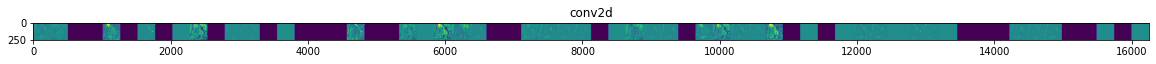

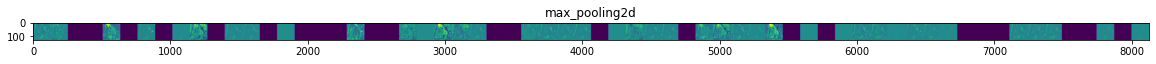

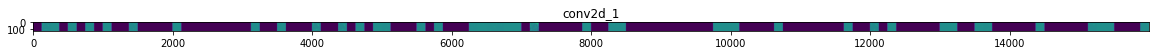

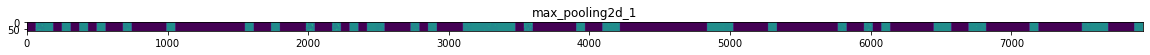

In [41]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

img = tf.keras.preprocessing.image.load_img(files[3], target_size=(256, 256) )
x=tf.keras.preprocessing.image.img_to_array(img)
print(x.shape)
x=x.reshape ((1, ) + x.shape)
print (x.shape)
x/=255
successive_feature_maps = visualization_model.predict(x)
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len (feature_map.shape) == 4:
    n_features = feature_map.shape[-1]
    print(feature_map.shape)
    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x= feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype ('uint8')
      display_grid[:, i*size : (i + 1) * size] = x
    scale =20. /n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

#10 random images with actual and predicted snakes breed from validation set

In [42]:
labels = dict((v,k) for k,v in train_generator.class_indices.items())
labels

{0: 'agkistrodon-contortrix',
 1: 'agkistrodon-piscivorus',
 2: 'coluber-constrictor',
 3: 'crotalus-atrox',
 4: 'crotalus-horridus',
 5: 'crotalus-ruber',
 6: 'crotalus-scutulatus',
 7: 'crotalus-viridis',
 8: 'diadophis-punctatus',
 9: 'haldea-striatula',
 10: 'heterodon-platirhinos',
 11: 'lampropeltis-californiae',
 12: 'lampropeltis-triangulum',
 13: 'masticophis-flagellum',
 14: 'natrix-natrix',
 15: 'nerodia-erythrogaster',
 16: 'nerodia-fasciata',
 17: 'nerodia-rhombifer',
 18: 'nerodia-sipedon',
 19: 'opheodrys-aestivus',
 20: 'pantherophis-alleghaniensis',
 21: 'pantherophis-emoryi',
 22: 'pantherophis-guttatus',
 23: 'pantherophis-obsoletus',
 24: 'pantherophis-spiloides',
 25: 'pantherophis-vulpinus',
 26: 'pituophis-catenifer',
 27: 'rhinocheilus-lecontei',
 28: 'storeria-dekayi',
 29: 'storeria-occipitomaculata',
 30: 'thamnophis-elegans',
 31: 'thamnophis-marcianus',
 32: 'thamnophis-proximus',
 33: 'thamnophis-radix',
 34: 'thamnophis-sirtalis'}

In [43]:
pred_labels = [] 
actuals = []
pred = np.argmax(model.predict(val_generator), axis=1)
for i in range(551):
    pred_labels.append(labels[pred[i]])
    actuals.append(labels[val_generator.classes[i]])

In [44]:
val_df = pd.DataFrame(columns=['file', 'pred_labels', 'actuals'])
val_df['file'] = val_generator.filenames
val_df['predicted_labels'] = pred_labels
val_df['actuals_data'] = actuals
val_df.head()

,file,pred_labels,actuals,predicted_labels,actuals_data
0,/content/dataset/train/b0f58084e4.jpg,NaN,NaN,storeria-dekayi,thamnophis-elegans
1,/content/dataset/train/7f6754b25d.jpg,NaN,NaN,thamnophis-sirtalis,thamnophis-radix
2,/content/dataset/train/45652aebed.jpg,NaN,NaN,nerodia-sipedon,pantherophis-spiloides
3,/content/dataset/train/d7b05b95e9.jpg,NaN,NaN,thamnophis-sirtalis,pantherophis-obsoletus
4,/content/dataset/train/ad19d7bf51.jpg,NaN,NaN,pantherophis-obsoletus,pantherophis-obsoletus


In [45]:
sample = pd.DataFrame(val_df.sample(10))


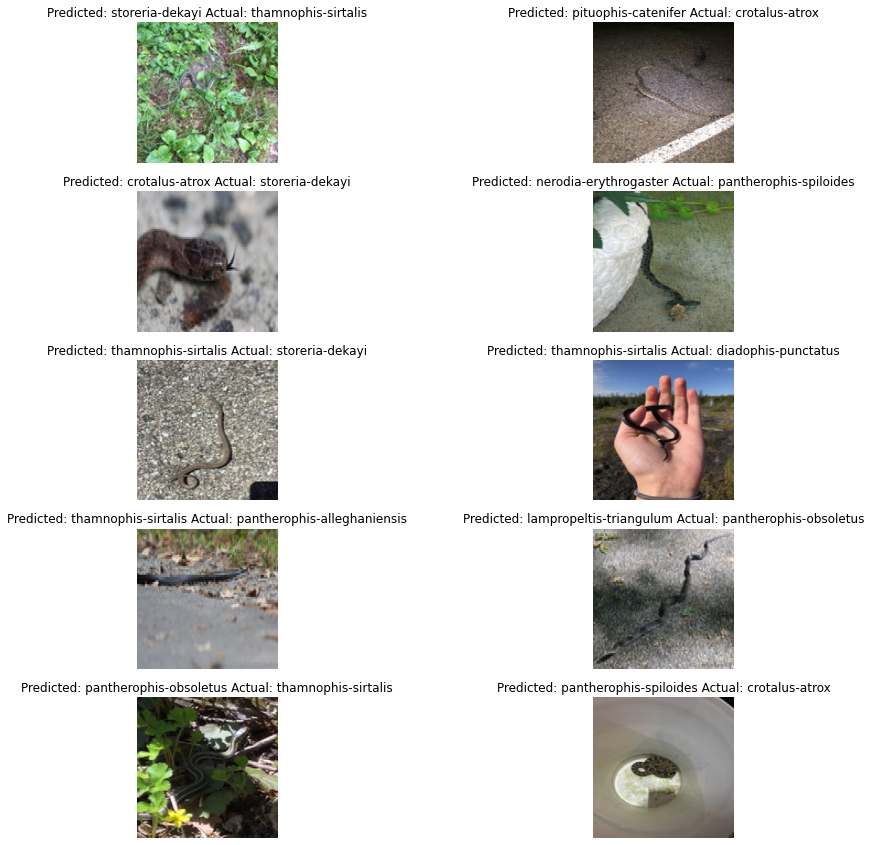

In [46]:
j=1
plt.figure(figsize=(15,15))
for i in sample.index:

  plt.subplot(5, 2, j)
  img = tf.keras.preprocessing.image.load_img(sample['file'][i], target_size = (256, 256))
  plt.imshow(img)
  plt.axis("off")
  plt.title("Predicted: " + val_df['predicted_labels'][i] + " Actual: " + val_df['actuals_data'][i])
  j+=1